## Question 1: **Answer**

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [ ]:
def add_data_to_database(input_data):
    try:
        df = pd.read_csv(input_data)
        engine = sqlite3.connect('farming_business_records.db')
        df.to_sql('farm_records', con=engine, index = False)
    except Exception as e:
        print(f"Error: {e}")

# Loading data
data = "/content/farming_business.csv"
add_data_to_database(data)

In [3]:
# Loading SQL extension
%load_ext sql

In [4]:
# Connecting to the database
%sql sqlite:///farming_business_records.db

In [5]:
# Default to duplicated style
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

In [6]:
%%sql
SELECT * FROM farm_records
LIMIT 5;

 * sqlite:///farming_business_records.db
Done.


date,crop,quantity_harvested,price_per_unit,expenses,sold,unsold,location,weather
10 01 2019,Wheat,1000,0.5,800,750,250,Sunnyside Meadows,Sunny
15 01 2019,Lettuce,500,1.25,300,400,100,Windmill Ridge,Rainy
20 01 2019,Tomatoes,250,2.0,400,150,100,Sunnyside Meadows,Snowy
25 01 2019,Potatoes,800,0.75,500,600,200,Windmill Ridge,Cloudy
1 02 2019,Corn,1500,0.4,900,1200,300,Sunnyside Meadows,Sunny
5 02 2019,Carrots,300,1.5,200,250,50,Windmill Ridge,Windy
10 02 2019,Apples,750,1.75,500,650,100,Sunnyside Meadows,Foggy
15 02 2019,Strawberries,125,3.0,200,75,50,Windmill Ridge,Sunny
20 02 2019,Spinach,400,1.0,250,300,100,Sunnyside Meadows,Rainy
25 02 2019,Bell Peppers,200,2.5,300,150,50,Windmill Ridge,Cloudy


## Question 2: **Answer**

In [7]:
%%sql
SELECT
    crop,
    SUM(price_per_unit * sold) AS total_revenue
FROM farm_records
GROUP BY crop
ORDER BY total_revenue DESC
LIMIT 3;

 * sqlite:///farming_business_records.db
Done.


crop,total_revenue
Apples,1137.5
Watermelon,1100.0
Grapes,1000.0


## Question 3: **Answer**

In [8]:
%%sql
-- Calculate total harvested and percentages for each weather condition
WITH percentages_calculation AS (
    SELECT
        weather,
        SUM(quantity_harvested) AS total_harvested,
        ROUND(SUM(sold) * 100.0 / SUM(quantity_harvested), 2)
        AS percentage_sold,
        ROUND(SUM(unsold) * 100.0 / SUM(quantity_harvested), 2)
        AS percentage_unsold,
        ROUND(ABS(SUM(sold) - SUM(unsold)) * 100.0 / SUM(quantity_harvested), 2)
        AS percent_difference
    FROM farm_records
    GROUP BY weather
),
-- Identify the maximum percentage difference across all weather conditions
max_percentage_difference AS (
    SELECT MAX(percent_difference) AS difference
    FROM percentages_calculation
)
-- Retrieve the weather condition with the largest percentage difference
SELECT
    pc.weather,
    pc.total_harvested,
    pc.percentage_sold,
    pc.percentage_unsold,
    pc.percent_difference
FROM percentages_calculation pc
JOIN max_percentage_difference mp
ON pc.percent_difference = mp.difference;

 * sqlite:///farming_business_records.db
Done.


weather,total_harvested,percentage_sold,percentage_unsold,percent_difference
Foggy,2075,83.13,16.87,66.27


## Question 4: **Answer**

In [9]:
%%sql
-- Calculate the total revenue and costs per location
WITH farm_totals AS (
  SELECT
          location,
          SUM(quantity_harvested * price_per_unit) AS
          total_revenue,
          SUM(expenses) AS total_expenses
  FROM farm_records
  GROUP BY location
),
-- Calculate the difference between revenue and expences
profit_calculation AS (
    SELECT (total_revenue - total_expenses) AS profit
    FROM farm_totals
),
-- Retrieve the minimum profit
minimum_profit AS (
    SELECT MIN(profit)
    AS revenue_cost_difference
    FROM profit_calculation
)
-- Return the location with the least profit
SELECT
       location AS farm_name,
       total_revenue - total_expenses AS profit,
       -- Calculating the profit margin
       printf('%20s', ROUND((total_revenue - total_expenses) /
                      total_revenue * 100, 2)) AS profit_margin
FROM farm_totals
WHERE profit = (SELECT revenue_cost_difference
                FROM minimum_profit);

 * sqlite:///farming_business_records.db
Done.


farm_name,profit,profit_margin
Windmill Ridge,2762.5,49.0


## Question 5: **Answer**

In [10]:
%%sql
WITH crop_inventory AS (
  SELECT
      crop,
      quantity_harvested,
      (quantity_harvested - sold) AS inventory_level,
      ROUND(((quantity_harvested - sold) * 100.0) / quantity_harvested, 2)
      AS inventory_percentage
  FROM farm_records
),
ranked_inventory AS (
  SELECT
      crop,
      quantity_harvested,
      inventory_level,
      inventory_percentage,
      RANK() OVER (ORDER BY inventory_percentage DESC)
      AS rank_by_inventory
  FROM crop_inventory
)
SELECT
    crop,
    quantity_harvested,
    inventory_level,
    inventory_percentage,
    rank_by_inventory
FROM ranked_inventory
WHERE rank_by_inventory = 1;

 * sqlite:///farming_business_records.db
Done.


crop,quantity_harvested,inventory_level,inventory_percentage,rank_by_inventory
Strawberries,150,65,43.33,1


## Question 5: **Answer**

In [11]:
%%sql
SELECT
    crop,
    COUNT(*) AS harvest_count,
    SUM(quantity_harvested) AS total_harvested
FROM farm_records
GROUP BY crop
HAVING harvest_count > 1;

 * sqlite:///farming_business_records.db
Done.


crop,harvest_count,total_harvested
Bell Peppers,2,425
Carrots,2,625
Lettuce,2,1050
Strawberries,2,275
Tomatoes,2,525


In [12]:
# Assign query to variable
query = """
SELECT
    crop,
    COUNT(*) AS harvest_count,
    SUM(quantity_harvested) AS total_harvested
FROM farm_records
GROUP BY crop
HAVING harvest_count > 1;
"""
# Connect to database
conn = sqlite3.connect("farming_business_records.db")

In [13]:
# Creating a DataFrame from query
df = pd.read_sql_query(query, conn)
print(df)

           crop  harvest_count  total_harvested
0  Bell Peppers              2              425
1       Carrots              2              625
2       Lettuce              2             1050
3  Strawberries              2              275
4      Tomatoes              2              525


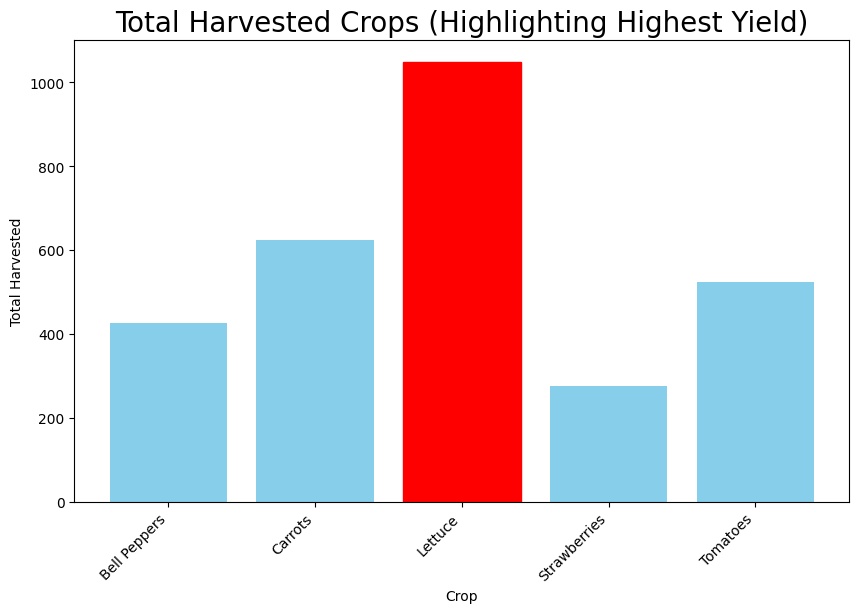

In [14]:
# Creating a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(df["crop"], df["total_harvested"], color="skyblue")

# Finding the crop with the highest total harvest
max_harvest_crop = df.loc[df["total_harvested"].idxmax(), "crop"]

# Highlighting the crop with the highest harvest
for bar, crop in zip(bars, df["crop"]):
    if crop == max_harvest_crop:
        bar.set_color("red")

plt.xlabel("Crop")
plt.ylabel("Total Harvested")
plt.title("Total Harvested Crops (Highlighting Highest Yield)", fontsize=20)
plt.xticks(rotation=45, ha="right")
plt.show()
# Closing connection
conn.close()